In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from pathlib import Path

from phystem.systems.ring import utils

In [29]:
root_dir = Path("data/teste/delta/debug")

class State:
    def __init__(self, pos, angle, ids):
        self.pos = pos
        self.angle = angle
        self.ids = ids

def load_point(id):
    main_dir = root_dir / f"point_{id}"

    cm_paths = [
        main_dir / f"cm_{id}_i.npy",
        main_dir / f"cm_{id}_f.npy",
    ]
    links_paths = [
        main_dir / f"links_{id}_i.npy",
        main_dir / f"links_{id}_f.npy",
    ]

    cms = [np.load(cm_paths[i]) for i in range(2)]
    
    links = []
    for i in range(2):
        with open(links_paths[i], "rb") as f:
            links.append(pickle.load(f))
    
    state_dir = main_dir / "state"
    states = []
    for suf in ["i", "f"]:
        pos = np.load(state_dir / f"pos_{suf}.npy") 
        angle = np.load(state_dir / f"angle_{suf}.npy") 
        ids = np.load(state_dir / f"ids_{suf}.npy") 
        states.append(State(pos, angle, ids))
    
    center_mask = np.load(main_dir / "in_center.npy")
    deltas = np.load(main_dir / "deltas.npy")

    return cms, links, center_mask, deltas, states

def create_colors(states):
    max_id = max([states[i].ids.max() for i in range(2)])
    return np.random.random(max_id+1)

def get_colors(ids, num_p, colors):
    c = np.zeros(ids.size*num_p, dtype=float)

    for i in range(ids.size):
        start_id = num_p*i
        end_id = num_p*(i+1)
        c[start_id:end_id] = colors[ids[i]]

    return c

def calc_delta(cms, links, ring_id):
    cm1, cm2 = cms[0][ring_id], cms[1][ring_id]

    l1 = links[0][ring_id]
    l2 = links[1][ring_id]
    num_neighs = l1.shape[0]

    diff1 = np.square(l1 - cm1).sum(axis=1)
    diff2 = np.square(l2 - cm2).sum(axis=1)

    return 1 - (diff1/diff2).sum() / num_neighs

In [30]:
cfgs = utils.load_configs(root_dir / "point_0" / "state")
d = utils.get_ring_radius(cfgs["dynamic_cfg"].diameter, cfgs["creator_cfg"].num_p) * 2
d

4.80973434474413

In [49]:
cms, links, center_mask, deltas, states = load_point(2)
colors = create_colors(states)

rings_center_ids = []
for i, in_center in enumerate(center_mask):
    if in_center:
        rings_center_ids.append(i)
    
cms[0][:, 1].max()

20.948372724324688

delta_data:  0.22011332923224158
delta:  0.22011332923224158
equal:  False


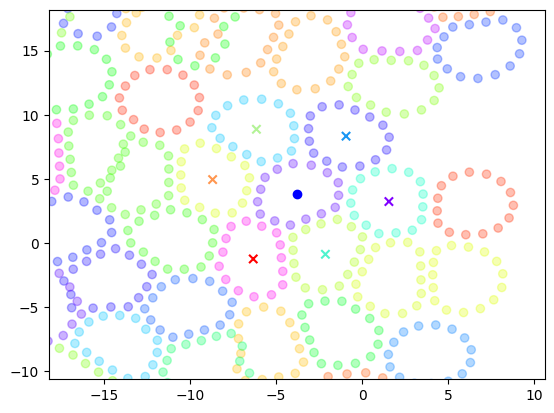

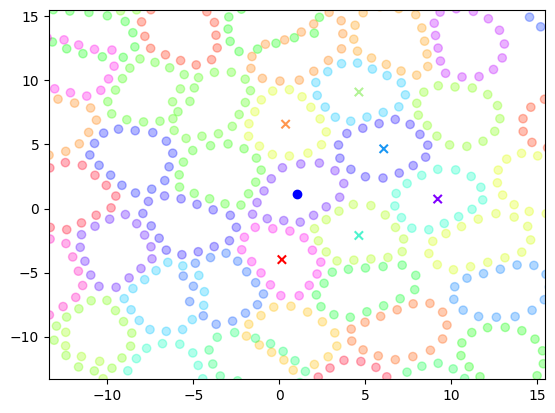

In [50]:
# ring_id = 0
ring_id = rings_center_ids[-1]

if center_mask[ring_id]:
    d1 = deltas[center_mask[:ring_id].sum()]
    d2 = calc_delta(cms, links, ring_id)

    print("delta_data: ", d2)
    print("delta: ", d2)
    print("equal: ", d1 == d2)
else:
    print("Não está no centro")

for id in range(2):
    links[id][0]
    plt.scatter(*utils.pos_to_scatter(states[id].pos), 
        c=get_colors(states[id].ids, 15, colors),
        cmap="gist_rainbow", alpha=0.3)

    window_size = 3
    cmi = cms[id][ring_id]
    plt.xlim(cmi[0]-window_size*d, cmi[0]+window_size*d)
    plt.ylim(cmi[1]-window_size*d, cmi[1]+window_size*d)

    num_neighs = links[id][ring_id].shape[0]
    neigh_c = np.linspace(0, 1, num_neighs)

    plt.scatter(*cms[id][ring_id], c="blue")
    plt.scatter(*links[id][ring_id].T, c=neigh_c, cmap="rainbow", marker="x")
    plt.show()

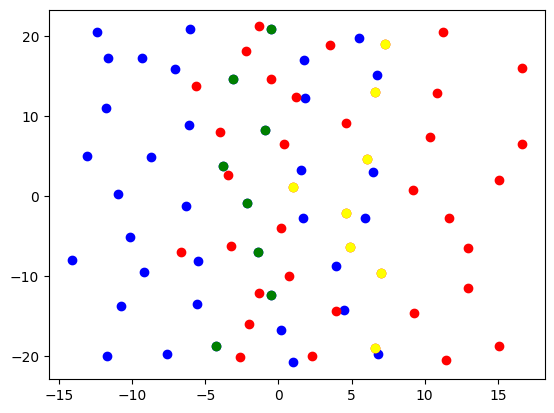

In [51]:
plt.scatter(*cms[0].T, c="blue")
plt.scatter(*cms[0][center_mask].T, c="green")
plt.scatter(*cms[1].T, c="red")
plt.scatter(*cms[1][center_mask].T, c="yellow")
plt.show()